<a href="https://colab.research.google.com/github/dscho15/deep-learning/blob/main/Lecture8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Varational Autoencoder

The behaviour of the VAE is far from satisfactory, there are a lot of pratical challenges that hinders good results. 

- Balacing issue, the VAE loss function is comprised of two terms, the log-likelihood, that reduces the reconstruction error and the Kullback-Leibler divergence, acting as a regularizer of the latent space. Finding a proper relationship, between those two is a hard problem.

- Training issues, VAE approximate expectations through sampling when trained, that could increase variance in gradients. 

- Variable collapse phenomenon

- Aggregate posterior vs expected prior mistmatch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
gdd.download_file_from_google_drive('1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk', '~/img_align_celeba_50k.npz')
blob = np.load('~/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

x_train shape: (48000, 32, 32, 3)
x_valid shape: (2000, 32, 32, 3)
dtype: float32


In [3]:
x_train_blur = np.empty_like(x_train)
for i in tqdm(range(len(x_train))):
  # apply your noise model here
  # x_train_blur[i] = cv2.GaussianBlur(x_train[i], (3, 3), cv2.BORDER_DEFAULT)
  x_train_blur[i] = x_train[i]

x_valid_blur = np.empty_like(x_valid)
for i in tqdm(range(len(x_valid))):
  # apply your noise model here
  # x_valid_blur[i] = cv2.GaussianBlur(x_valid[i], (3, 3), cv2.BORDER_DEFAULT)
  x_valid_blur[i] = x_valid[i]

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
  return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
  return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_blur_normed = norm(x_train_blur)
x_valid_blur_normed = norm(x_valid_blur)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


In [50]:
class Reshape(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args

  def forward(self, x):
    return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self, *args):
    super().__init__()

  def forward(self, x):
    return x[:, :, :32, :32]

class VAE(nn.Module):

  def __init__(self, 
               input_channels = 3,
               hidden_channels = 32,
               kernel_size = 3,
               latent_dim = 64):

    super(VAE, self).__init__()

    self.encode = model = nn.Sequential(  
                                          #
                                          nn.Conv2d(input_channels, hidden_channels, kernel_size, stride = 2, bias=False, padding = 1),
                                          nn.BatchNorm2d(hidden_channels),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.10),
                                          #
                                          nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size, stride = 2, bias=False, padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.25),
                                          #
                                          nn.Conv2d(hidden_channels*2, hidden_channels*2, kernel_size, stride = 2, bias=False, padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.10),
                                          #
                                          nn.Conv2d(hidden_channels*2, hidden_channels*2, kernel_size, stride = 2, bias=False, padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.25),
                                          #
                                          nn.Flatten() # B x 64 x 2 x 2 -> B x 64 * 2**2
                                        )


    self.decode = model = nn.Sequential(  
                                          nn.Linear(latent_dim, hidden_channels * 2**3),
                                          Reshape(-1, 64, 2, 2),
                                          #
                                          nn.ConvTranspose2d(hidden_channels*2, hidden_channels*2, kernel_size, stride = 2),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.25),
                                          #
                                          nn.ConvTranspose2d(hidden_channels*2, hidden_channels*2, kernel_size, stride = 2, padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Dropout2d(0.10),
                                          #
                                          nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size, stride = 2, padding = 1),
                                          nn.BatchNorm2d(hidden_channels),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          
                                          #
                                          nn.ConvTranspose2d(hidden_channels, input_channels, kernel_size, stride = 2, padding = 1),
                                          Trim(),
                                          nn.Sigmoid()
                                        )
    
    self.fc_mu = nn.Linear(hidden_channels * 2**3, latent_dim)
    self.fc_log_var = nn.Linear(hidden_channels * 2**3, latent_dim)
    self.latent_dim = latent_dim

  def forward(self, x):
    """
    :param x: the batch input, an image.
    """

    # encoder part - output is a B x 64 x 2 x 2
    h = self.encode(x)

    # calculate mu and var
    self.mu = self.fc_mu(h)
    self.log_var = self.fc_log_var(h)

    # mu and var is techinically the ouput of the encoder.
    self.p = self.reparameterize(self.mu, self.log_var)

    y = self.decode(self.p)

    return [h, self.mu, self.log_var, y]

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """

    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # we need same size as std

    sample = mu + (eps * std)

    return sample

  def sample(self, num_samples, **kwargs):
    """
    Samples from the latent space and return the corresponding
    image space map.
    :param num_samples: (Int) Number of samples
    :param current_device: (Int) Device to run the model
    :return: (Tensor)
    """
    z = torch.randn(num_samples, self.latent_dim)

    z = z.cuda()

    samples = self.decode(z)

    return samples


In [51]:
train_data = list(zip(x_train_blur_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=12)

valid_data = list(zip(x_valid_blur_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=12)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss (train/valid): 1607.5308/1450.2466, kl_div (train): 29.2071/30.8547
epoch: 1, loss (train/valid): 1507.2837/1438.9310, kl_div (train): 30.5506/29.5196
epoch: 2, loss (train/valid): 1497.1532/1432.2134, kl_div (train): 29.9711/29.6064
epoch: 3, loss (train/valid): 1491.6473/1427.2687, kl_div (train): 29.8839/29.4017
epoch: 4, loss (train/valid): 1486.9117/1423.0121, kl_div (train): 29.6720/28.7199
epoch: 5, loss (train/valid): 1483.9176/1424.2356, kl_div (train): 29.4783/29.0732
epoch: 6, loss (train/valid): 1481.8097/1419.6844, kl_div (train): 29.4846/29.0051
epoch: 7, loss (train/valid): 1479.7040/1417.9492, kl_div (train): 29.4671/28.3733
epoch: 8, loss (train/valid): 1478.6753/1418.2430, kl_div (train): 29.4333/28.7038
epoch: 9, loss (train/valid): 1476.7813/1416.8791, kl_div (train): 29.4163/28.6864


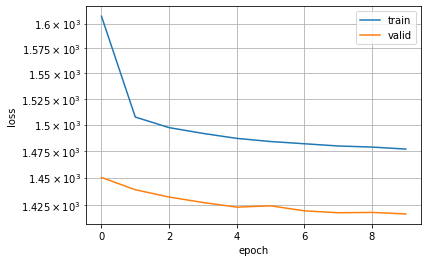

In [55]:
model = VAE(input_channels = 3, hidden_channels = 32, kernel_size = 3, latent_dim = 8).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []
beta = 2e-1

for epoch in tqdm(range(10)):
   
    # train
    model.train()
    losses, kld_losses = [], []
    for x, y in train_dataloader:

      x, y = x.cuda(), y.cuda()

      encoded, mu, log_var, decoded  = model(x)

      # total loss = reconstruction loss + kl divergence
      # kl_div first
      kl_div = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1))
      
      # reconstruction loss
      recon_loss_pixelwise = F.mse_loss(decoded, y, reduction='none')
      recon_loss_pixelwise = recon_loss_pixelwise.view(64, -1).sum(axis=1)
      recon_loss_pixelwise = recon_loss_pixelwise.mean()
      
      # total loss
      loss = (1-beta)*recon_loss_pixelwise + (beta)*kl_div

      opt.zero_grad()
      loss.backward()
      opt.step()

      losses.append(loss.item())
      kld_losses.append(kl_div.item())

    train_losses.append(np.mean(losses))
    kld_loss_train = np.mean(kld_losses)

    ##

    model.eval()
    losses, kld_losses = [], []
    with torch.no_grad():

      for x, y in valid_dataloader:

          x, y = x.cuda(), y.cuda()

          encoded, mu, log_var, decoded  = model(x)

          # https://www.borealisai.com/en/blog/tutorial-5-variational-auto-encoders/
          # total loss = reconstruction loss + kl divergence
          # kl_div first
          kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1)
          kl_div = kl_div.mean()
          
          # reconstruction loss
          recon_loss_pixelwise = F.mse_loss(decoded, y, reduction='none')
          recon_loss_pixelwise = recon_loss_pixelwise.view(64, -1).sum(axis=1)
          recon_loss_pixelwise = recon_loss_pixelwise.mean()
          
          # total loss
          loss = (1-beta)*recon_loss_pixelwise + (beta)*kl_div

          losses.append(loss.item())
          kld_losses.append(kl_div.item())

      valid_losses.append(np.mean(losses))
      kld_loss_valid = np.mean(kld_losses)

    print(f'epoch: {epoch}, loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}, kl_div (train): {kld_loss_train:.4f}/{kld_loss_valid:.4f}')

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()

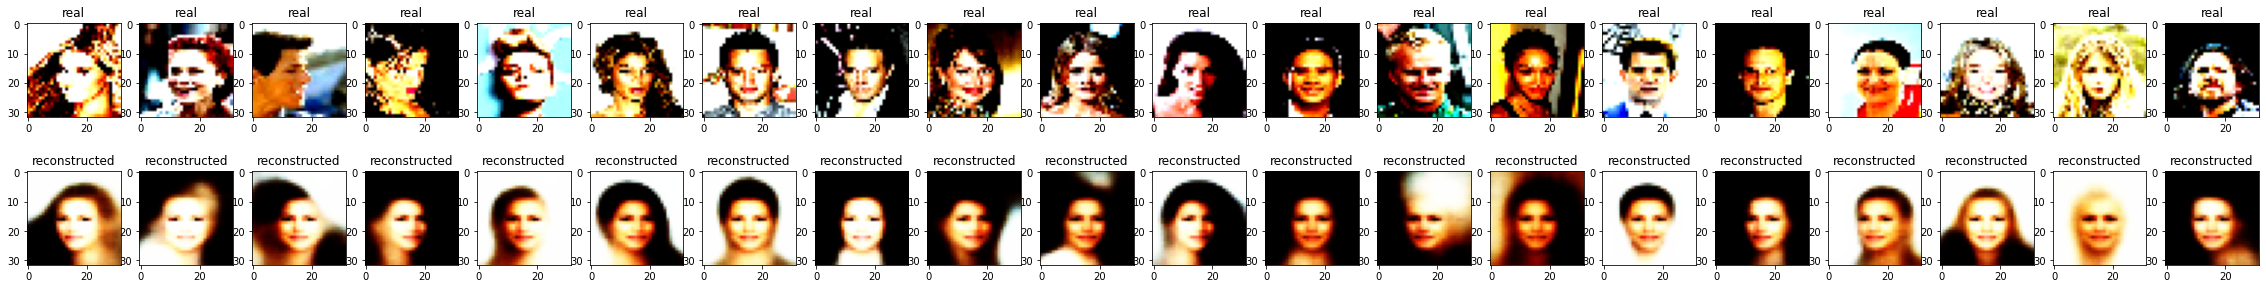

In [56]:
def plt_real_vs_recon(cols):
  plt.figure(1, figsize=(2*cols, 5))
  for i in range(cols):
    plt.subplot(2, cols, i+1)
    img = train_data[i][0].reshape((1, 3, 32, 32))
    img = img.cpu().detach().numpy().reshape((3, 32, 32)).transpose(1, 2, 0)
    plt.title("real")
    plt.imshow(np.clip(img, 0, 1))
  model.eval()
  for i in range(cols):
    plt.subplot(2, cols, i+1 + cols)
    img = train_data[i][0].reshape((1, 3, 32, 32)).cuda()
    _, _, _ , img_ae = model.forward(img)
    img_ae = img_ae.cpu().detach().numpy().reshape((3, 32, 32)).transpose(1, 2, 0)
    plt.title("reconstructed")
    plt.imshow(np.clip(img_ae, 0, 1))
  plt.show()

plt_real_vs_recon(20)

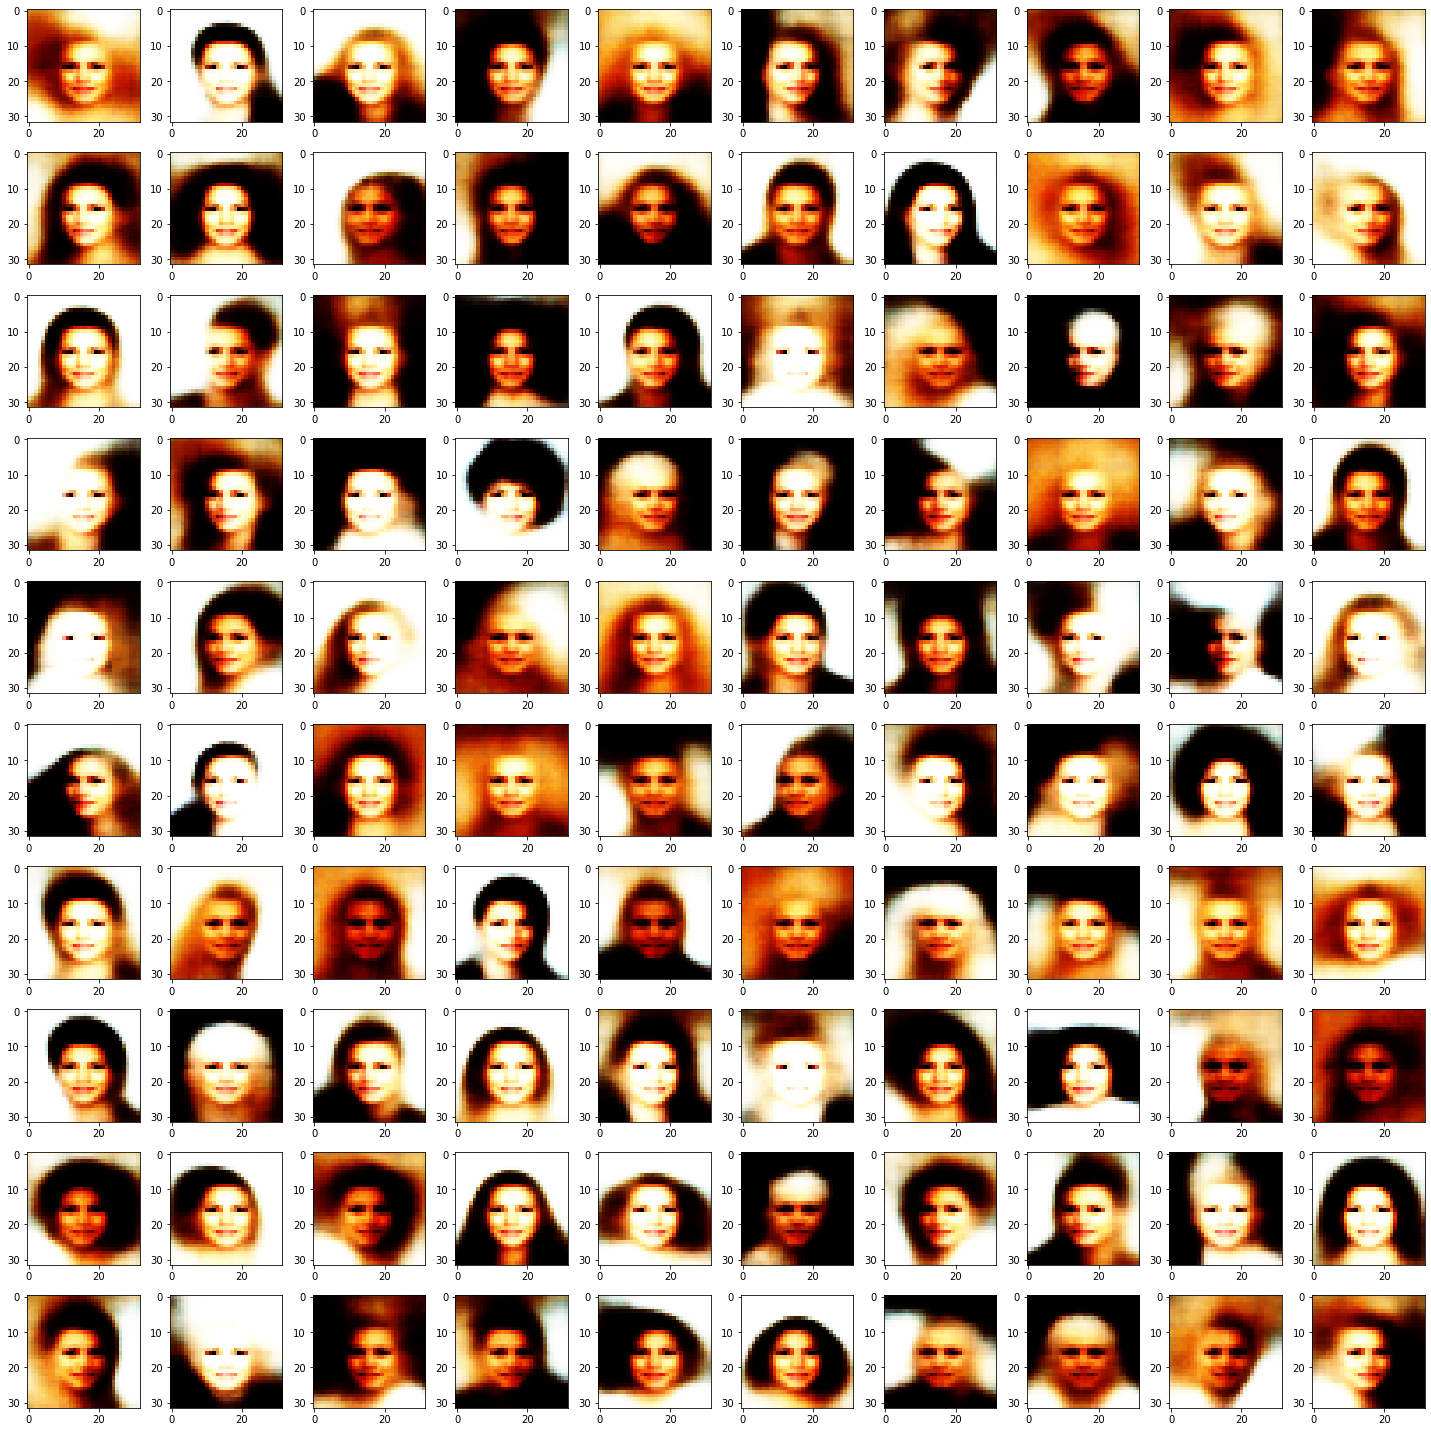

In [57]:
def plot_imgs(rows, cols):
  plt.figure(1, figsize=(rows*2, cols*2))
  imgs = model.sample(rows*cols)
  for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    img = imgs[i].cpu().detach().numpy()
    img = img.reshape((3, 32, 32)).transpose(1, 2, 0)
    plt.imshow(np.clip(img, 0, 1)) 
  plt.tight_layout()
  plt.show()

plot_imgs(10, 10)

# Online resources that deserves credit

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

https://www.youtube.com/watch?v=IQpP_cH8rrA

https://github.com/rasbt/stat453-deep-learning-ss21

https://github.com/seasonyc/face_vae/blob/master/face_vae.py

# Papers

https://www.researchgate.net/publication/339471396_Variance_Loss_in_Variational_Autoencoders/link/5f7b281392851c14bcaeeda5/download